#MOTO GP

In [3]:
import pandas as pd

#import the datasets
riders_position = pd.read_csv("/content/drive/MyDrive/riders-finishing-positions.csv")
same_nation = pd.read_csv("/content/drive/MyDrive/same-nation-podium-lockouts.csv")
constructors_data = pd.read_csv("/content/drive/MyDrive/constructure-world-championship.csv")

##RIDERS FINISHING POSITIONS MOTOGP

###CREATE RDF

In [4]:
from os import read
import csv
from rdflib import Graph, Namespace, Literal, RDF, URIRef, XSD, BNode, OWL, RDFS
import pandas as pd

riders_position['Rider'] = riders_position['Rider'].apply(lambda x: x.upper())
riders_position['Rider'] = riders_position['Rider'].apply(lambda x: x.replace(' ', '_'))

g1 = Graph()

#Prefix###############################################
re = Namespace('http://example.org/motor-sports/motoGP/')
ms = Namespace('http://example.org/motor-sports/')
dbo = Namespace("http://dbpedia.org/ontology/")
FOAF = Namespace("http://xmlns.com/foaf/0.1/")
d = Namespace("http://example.org/motor-sports/formula-one/")
co = Namespace("http://example.org/motor-sports/formula-one/")
g1.bind("d" , d)
g1.bind("co" , co)
g1.bind("re" , re)
g1.bind("ms" , ms)
g1.bind("dbo" , dbo)
g1.bind("FOAF" , FOAF)

# Add classes #########################################
g1.add((re.Rider, RDF.type, OWL.Class))
g1.add((ms.Racers, RDF.type, OWL.Class))
g1.add((dbo.Person, RDF.type, OWL.Class))

#Add subclass##########################################
g1.add((re.Rider, RDFS.subClassOf, ms.Racers))
g1.add((ms.Racers, RDFS.subClassOf, dbo.Person))

#Add distjointunionOf#############################################
dis = BNode()
g1.add((ms.Racers, OWL.disjointUnionOf, dis ))
g1.add((dis, RDF.first, re.Rider ))
dis2 = BNode()
g1.add((dis, RDF.rest, dis2 ))
g1.add((dis2, RDF.first, d.Driver))
g1.add((dis2, RDF.rest, RDF.nil ))


# Add Properties####################################################
g1.add((re.HadFirstPlaces, RDF.type, OWL.DatatypeProperty))
g1.add((re.HadFirstPlaces, RDFS.domain, re.Rider))

g1.add((re.HadSecondPlaces, RDF.type, OWL.DatatypeProperty))
g1.add((re.HadSecondPlaces, RDFS.domain, re.Rider))

g1.add((re.HadThirdPlaces, RDF.type, OWL.DatatypeProperty))
g1.add((re.HadThirdPlaces, RDFS.domain, re.Rider))

g1.add((re.HadFourthPlaces, RDF.type, OWL.DatatypeProperty))
g1.add((re.HadFourthPlaces, RDFS.domain, re.Rider))

g1.add((re.HadFifthPlaces, RDF.type, OWL.DatatypeProperty))
g1.add((re.HadFifthPlaces, RDFS.domain, re.Rider))

g1.add((re.HadSixthPlaces, RDF.type, OWL.DatatypeProperty))
g1.add((re.HadSixthPlaces, RDFS.domain, re.Rider))

g1.add((re.RidersNation, RDF.type, OWL.DatatypeProperty))
g1.add((re.RidersNation, RDFS.domain, re.Rider))

#declare Riders as dinstinct#################################################
# Define owl:distinctMembers property
distinct_members_list = BNode()
g1.add((re.Rider, OWL.distinctMembers, distinct_members_list))

for i in range(len(riders_position['Rider'])-1):
  next_individual = BNode()
  g1.add((distinct_members_list, RDF.first, re[riders_position['Rider'][i]]))
  g1.add((distinct_members_list, RDF.rest, next_individual))
  distinct_members_list = next_individual

# For the last element, set RDF.rest to RDF.nil
g1.add((distinct_members_list, RDF.first, re[riders_position['Rider'][len(riders_position['Rider'])-1]]))
g1.add((distinct_members_list, RDF.rest, RDF.nil))

#Create rdf ##################################################################################################
# riders and count of wins from position 1 to 6 + country code
for row in riders_position.values:

  name = row[0].split('_')
  surname = '_'.join(name[1:])
  fullname = '_'.join(name[:])

  g1.add((re[fullname], RDF.type, re.Rider))
  g1.add((re[fullname], FOAF.firstName, Literal(name[0])))
  g1.add((re[fullname], FOAF.surname, Literal(surname)))
  g1.add((re[fullname], re.RiderNationality, Literal(str(row[7]))))
  g1.add((re[fullname], re.HadFirstPlaces, Literal(str(row[1]),datatype=XSD.float)))
  g1.add((re[fullname], re.HadSecondPlaces, Literal(str(row[2]),datatype=XSD.float)))
  g1.add((re[fullname], re.HadThirdPlaces, Literal(str(row[3]),datatype=XSD.float)))
  g1.add((re[fullname], re.HadFourthPlaces, Literal(str(row[4]),datatype=XSD.float)))
  g1.add((re[fullname], re.HadFifthPlaces, Literal(str(row[5]),datatype=XSD.float)))
  g1.add((re[fullname], re.HadSixthPlaces, Literal(str(row[6]),datatype=XSD.float)))



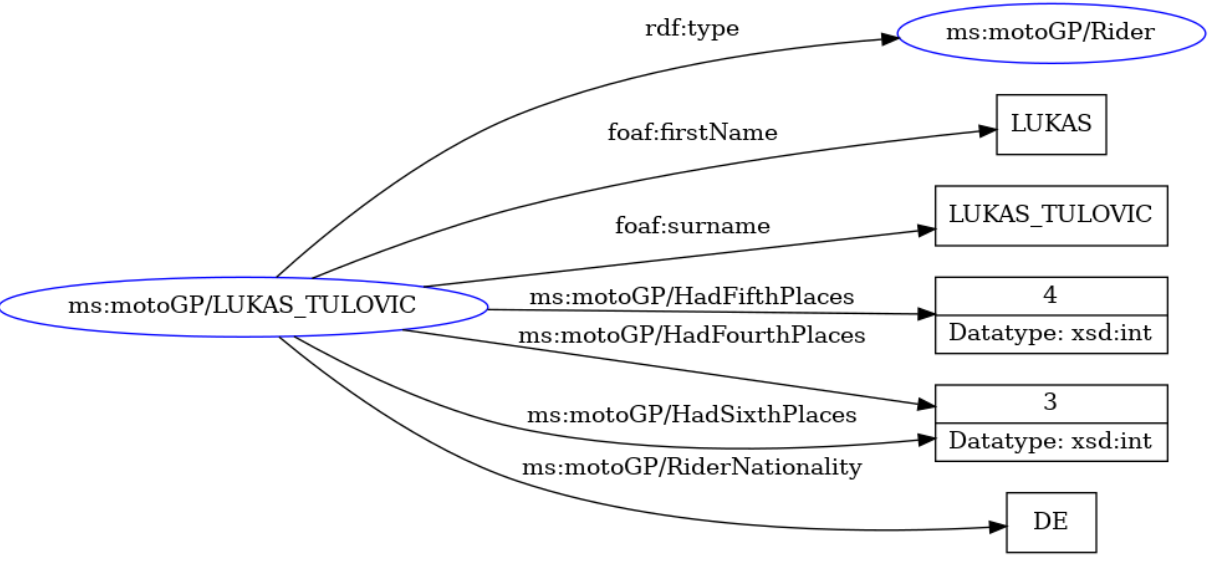

##PODIUM WITH SAME_NATION MOTOGP

###CSV PREPROCESSING

In [5]:
same_nation['Track'] = same_nation['Track'].apply(lambda x: x.replace(' ', '_'))

Track_class_array = []
Track_array = []
class_array = []
drivers_nation_array = []
season_array = []

#combine columns for id:track/class and get the season where the drives on the podium had the same nationality
for row in same_nation.values:
  current_track_class = row[1]+"_"+row[3]

  #if the compination already exist get the index and add country and season
  if current_track_class in Track_class_array:
    index = Track_class_array.index(current_track_class)
    season_array[index].append(row[0])
    drivers_nation_array[index].append(row[2])
  else:
    #if the combination doesnt exist add new entry in the arrays
    Track_array.append(row[1])
    class_array.append(row[3])
    Track_class_array.append(current_track_class)
    drivers_nation_array.append(list([row[2]]))
    season_array.append(list([row[0]]))

###CREATE RDF

In [6]:
g2 =Graph()
#Prefix #######################################
g2.bind("re" , re)

#add class########################################
g2.add((re.MotoRaceEvents, RDF.type, OWL.Class))

#add properties###################################
g2.add((re.Track, RDF.type, OWL.DatatypeProperty))
g2.add((re.Track, RDFS.domain, re.MotoRaceEvents))

g2.add((re.InClass, RDF.type, OWL.DatatypeProperty))
g2.add((re.InClass, RDFS.domain, re.MotoRaceEvents))

g2.add((re.SameNationPodium, RDF.type, OWL.DatatypeProperty))
g2.add((re.SameNationPodium, RDFS.domain, re.MotoRaceEvents))

g2.add((re.Inseason, RDF.type, OWL.DatatypeProperty))
g2.add((re.Inseason, RDFS.domain, re.MotoRaceEvents))

g2.add((re.RidersNation, RDF.type, OWL.DatatypeProperty))
g2.add((re.RidersNation, RDFS.domain, re.MotoRaceEvents))

#add triples for each track/class############################################
for i in range(len(Track_class_array)):

  g2.add((re[Track_class_array[i]], RDF.type, re.MotoRaceEvents))

  g2.add((re[Track_class_array[i]] , re.Track, re[str(Track_array[i])]))
  g2.add((re[Track_class_array[i]] , re.InClass, re[str(class_array[i])]))

  #for each season and country create a blank node
  for j in range(len(season_array[i])):
    b = BNode()
    g2.add((re[Track_class_array[i]] , re.SameNationPodium, b))
    g2.add((b, re.Inseason, Literal(str(season_array[i][j]), datatype = XSD.year)))
    g2.add((b, re.RidersNation, Literal(str(drivers_nation_array[i][j]), datatype = XSD.string)))


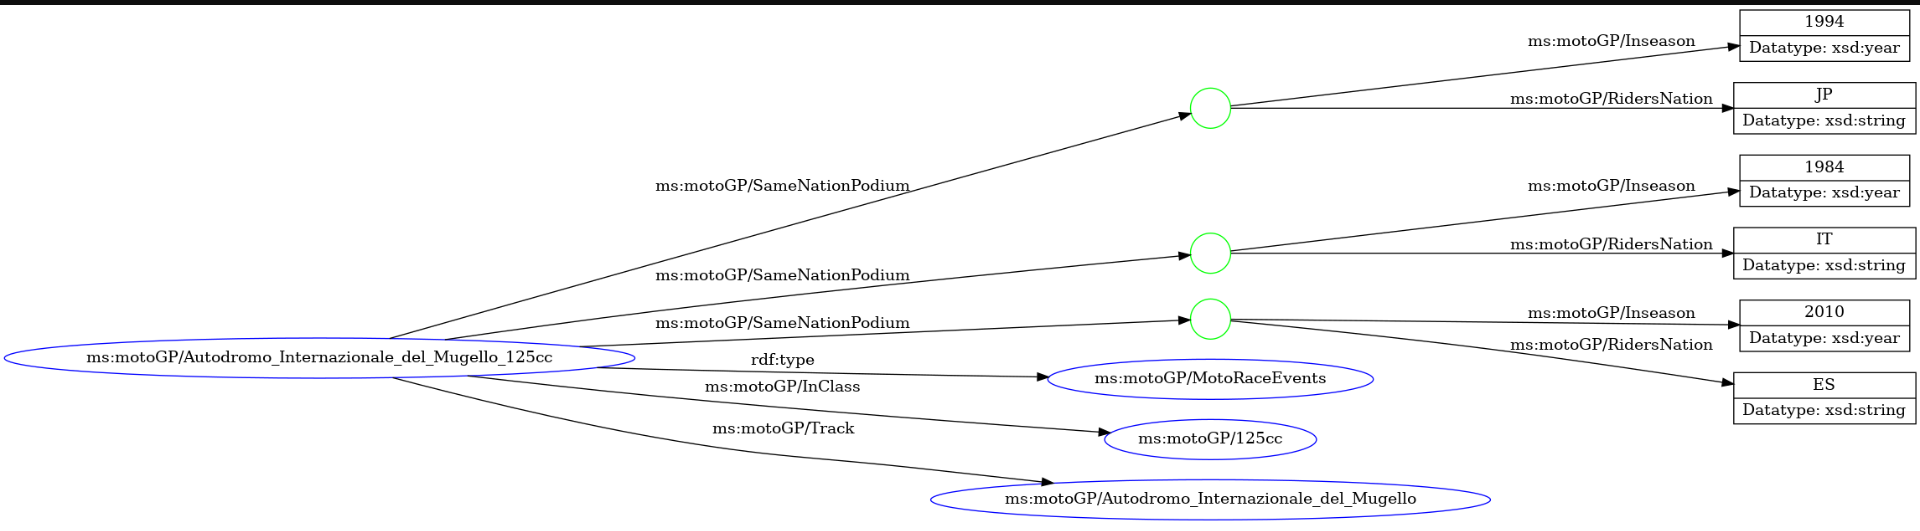

##CONSTRUCTORS CSV MOTOGP

###CSV PREPROCESSING

In [7]:
constructors_data['Constructor'] = constructors_data['Constructor'].apply(lambda x: x.replace(' ', '_'))
constructors_data = constructors_data.sort_values(by='Season')

constructor_array = []
season_array = []
class_array = []

for row in constructors_data.values:
  current_constructor = row[1]

  #if the constructor already exist get the index and add season
  if current_constructor in constructor_array:
    index = constructor_array.index(current_constructor)

    #exclude duplicates
    if row[0] not in season_array[index]:
      season_array[index].append(row[0])
    if row[2] not in class_array[index]:
      class_array[index].append(row[2])
  else:
    #if the combination doesnt exist add new entry in the arrays
    constructor_array.append(current_constructor)
    season_array.append(list([row[0]]))
    class_array.append(list([row[2]]))


range_of_seasons_array = []
total_seasons_array = []

#for each constructor
for idx,constructor in enumerate(constructor_array):

  total_seasons_array.append(len(season_array[idx]))
  prev_season = season_array[idx][0]
  range_of_seasons = str(season_array[idx][0])

  #for each season that the current constructor contribute
  flag = 0
  for idx,season in enumerate(season_array[idx]):

    #if the constructor contribute after some years add that information
    if (int(season)-int(prev_season)> 1 and idx != 0):
      #flag = 1 when its the time to close the range if its zero it means that we dont have range
      if flag == 1:
        range_of_seasons = range_of_seasons+"-"+str(prev_season)+", "+str(season)
        flag = 0;
      else:
        range_of_seasons = range_of_seasons+", "+str(season)
    #if the constructor contributes also the enxt year
    elif idx != 0:
      flag=1

    prev_season = season

  range_of_seasons_array.append(range_of_seasons)

###CREATE RDF

In [8]:
g3 = Graph()

#Prefix#######################################
g3.bind("re" , re)

# Add classes########################################
g3.add((re.MotoGPConstructor, RDF.type, OWL.Class))

#Subclass#########################################
g3.add((re.MotoGPConstructor, RDFS.subClassOf, ms.Constructors))

#Add unionOf#############################################
union = BNode()
g3.add((ms.Constructor, OWL.unionOf, union ))
g3.add((union, RDF.first, re.MotoGPConstructor ))
union2 = BNode()
g3.add((union, RDF.rest, union2 ))
g3.add((union2, RDF.first, co.F1Constructor))
g3.add((union2, RDF.rest, RDF.nil ))



# # Add Properties###############################################################
g3.add((re.ContribudeInSeasons, RDF.type, OWL.DatatypeProperty))
g3.add((re.ContribudeInSeasons, RDFS.domain, re.Constructor))

g3.add((re.TotalNumberOfSeasons, RDF.type, OWL.DatatypeProperty))
g3.add((re.TotalNumberOfSeasons, RDFS.domain, re.Constructor))

g3.add((re.InClasses, RDF.type, OWL.DatatypeProperty))
g3.add((re.InClasses, RDFS.domain, re.Constructor))
###############################################################
# for each constructor
for idx,constructor in enumerate(constructor_array):

  g3.add((re[constructor], RDF.type, re.MotoGPConstructor))
  g3.add((re[constructor], re.ContribudeInSeasons, Literal(str(range_of_seasons_array[idx]))))
  g3.add((re[constructor], re.TotalNumberOfSeasons, Literal(str(total_seasons_array[idx]),datatype=XSD.int)))
  for classs in class_array[idx]:
    g3.add((re[constructor], re.InClasses, Literal(str(classs))))


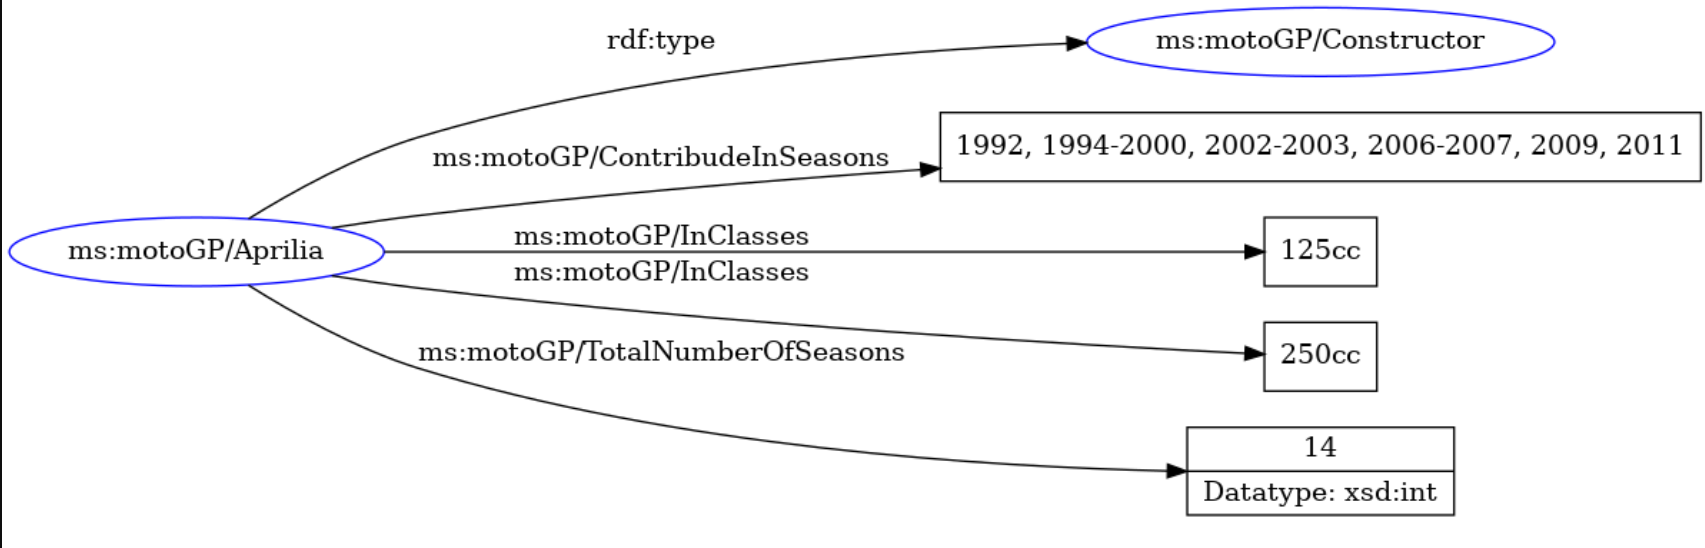

##COMBINE RDFS

In [9]:
g = Graph()
g = g1+g2+g3
turtle_data = g.serialize(format="turtle")
print(turtle_data)
with open('MotoGP_S_FinalOutPut.ttl', 'w') as f:
       f.write(turtle_data)

@prefix FOAF: <http://xmlns.com/foaf/0.1/> .
@prefix co: <http://example.org/motor-sports/formula-one/> .
@prefix dbo: <http://dbpedia.org/ontology/> .
@prefix ms: <http://example.org/motor-sports/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix re: <http://example.org/motor-sports/motoGP/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ms:Constructor owl:unionOf ( re:MotoGPConstructor co:F1Constructor ) .

re:AJS a re:MotoGPConstructor ;
    re:ContribudeInSeasons "1949" ;
    re:InClasses "MotoGP™" ;
    re:TotalNumberOfSeasons "1"^^xsd:int .

re:Albi_350cc a re:MotoRaceEvents ;
    re:InClass re:350cc ;
    re:SameNationPodium [ re:Inseason "1951"^^xsd:year ;
            re:RidersNation "GB"^^xsd:string ] ;
    re:Track re:Albi .

re:Anderstorp_125cc a re:MotoRaceEvents ;
    re:InClass re:125cc ;
    re:SameNationPodium [ re:Inseason "1987"^^xsd:yea